In [2]:
Packages <- c("nleqslv","viridis", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")

set.seed(7)

#define my own cv function
cv <- function(x){
    sd(x)/mean(x)
}

#make a mean dispersal distance function that can be applied to a DT rather than for loop method I've used in the past

mean_disp_dist <- function(k, theta){
    
x <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k, theta=theta, , method = "pcubature")$integral)

return(x)

}

In [15]:
#read in the simulation kernel fits
SimKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFits08DayPLD.csv")[, data_source := "simulation_08PLD"][
    time_id=="NEM", time_id := "Amihan"][
    time_id=="SWM", time_id := "Habagat"]
#SimKernels15PLD <- fread("~/oceanography/script_output/KernelFits/SimulationKernelFits15DayPLD.csv")[, data_source := "simulation_15PLD"][
#    time_id=="NEM", time_id := "Amihan"][
#    time_id=="SWM", time_id := "Habagat"]

#setnames(SimKernels, c("TimeID", "TimeScale"), c("time_id", "time_scale")) #from now on, DTs will be named LikeThis, vectors (including colnames and row ids) will be like_this- until I get around to making that consistent in every script, rename here
#read in the Genetics kernel fits with the same reef metadata structure
GenKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/GeneticKernelFits.csv")[
    time_id=="NEM", time_id := "Amihan"][
    time_id=="SWM", time_id := "Habagat"]

#read in the likelihood surfaces tables
#Genetics
ProfileGen2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/older_than_2022-01-24/LikelihoodProfileGenetic2012NarrowSearch.csv", header = T)
ProfileGen2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/older_than_2022-01-24/LikelihoodProfileGenetic2013NarrowSearch.csv", header = T)
ProfileGen2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/older_than_2022-01-24/LikelihoodProfileGenetic2014NarrowSearch.csv", header = T)
ProfileGen2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/older_than_2022-01-24/LikelihoodProfileGenetic2012_4NarrowSearch.csv", header = T)
ProfileGenNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/older_than_2022-01-24/LikelihoodProfileGeneticNEMNarrowSearch.csv", header = T)
ProfileGenSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/older_than_2022-01-24/LikelihoodProfileGeneticSWMNarrowSearch.csv", header = T)

#ROMS simulations
ProfileSim2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfile-Biophysical-2012-NarrowSearch-08DayPLD.csv", header = T)
ProfileSim2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfile-Biophysical-2013-NarrowSearch-08DayPLD.csv", header = T)
ProfileSim2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfile-Biophysical-2014-NarrowSearch-08DayPLD.csv", header = T)
ProfileSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfile-Biophysical-2012-4-NarrowSearch-08DayPLD.csv", header = T)
ProfileSimNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfile-Biophysical-NEM-NarrowSearch-08DayPLD.csv", header = T)
ProfileSimSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfile-Biophysical-SWM-NarrowSearch-08DayPLD.csv", header = T)

#ensure the likelihood surfaces found the same best fit as the bbmle optimization for both simulation and Geneticss
#done
#calculate the 95% likelihood surface cutoffs. Use the log_like from the bbmle function because that's more precise. in the grid search function used for the surfaces, k/theta are limited to 2 decimal places because it's less computation time, but in some cases that means the MLE is from an artificial local optimum that only exists because decimal places are truncated
#genetics
cutoff_Gen2012 <- min(ProfileGen2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012 <- ProfileGen2012[, `:=`(data_source="genetics", time_id="2012", cutoff=cutoff_Gen2012, best_k=GenKernels[time_id=="2012", k], best_theta=GenKernels[time_id=="2012", theta])]
ProfileGen2012_CI95 <- ProfileGen2012[log_like < cutoff_Gen2012]

cutoff_Gen2013 <- min(ProfileGen2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2013 <- ProfileGen2013[, `:=`(data_source="genetics", time_id="2013", cutoff=cutoff_Gen2013, best_k=GenKernels[time_id=="2013", k], best_theta=GenKernels[time_id=="2013", theta])]
ProfileGen2013_CI95 <- ProfileGen2013[log_like < cutoff_Gen2013]

cutoff_Gen2014 <- min(ProfileGen2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2014 <- ProfileGen2014[, `:=`(data_source="genetics", time_id="2014", cutoff=cutoff_Gen2014, best_k=GenKernels[time_id=="2014", k], best_theta=GenKernels[time_id=="2014", theta])]
ProfileGen2014_CI95 <- ProfileGen2014[log_like < cutoff_Gen2014]

cutoff_Gen2012_4 <- min(ProfileGen2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_4 <- ProfileGen2012_4[, `:=`(data_source="genetics", time_id="2012-4", cutoff=cutoff_Gen2012_4,  best_k=GenKernels[time_id=="2012-4", k], best_theta=GenKernels[time_id=="2012-4", theta])]
ProfileGen2012_4_CI95 <- ProfileGen2012_4[log_like < cutoff_Gen2012_4]

cutoff_GenNEM <- min(ProfileGenNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenNEM <- ProfileGenNEM[, `:=`(data_source="genetics", time_id="Amihan", cutoff=cutoff_GenNEM, best_k=GenKernels[time_id=="Amihan", k], best_theta=GenKernels[time_id=="Amihan", theta])]
ProfileGenNEM_CI95 <- ProfileGenNEM[log_like < cutoff_GenNEM]

cutoff_GenSWM <- min(ProfileGenSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenSWM <- ProfileGenSWM[, `:=`(data_source="genetics", time_id="Habagat", cutoff=cutoff_GenSWM, best_k=GenKernels[time_id=="Habagat", k], best_theta=GenKernels[time_id=="Habagat", theta])]
ProfileGenSWM_CI95 <- ProfileGenSWM[log_like < cutoff_GenSWM]

#biophysical simulation
cutoff_Sim2012 <- min(ProfileSim2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012 <- ProfileSim2012[, `:=`(data_source="simulation_08PLD", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]
ProfileSim2012_CI95 <- ProfileSim2012[log_like < cutoff_Sim2012]

cutoff_Sim2013 <- min(ProfileSim2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2013 <- ProfileSim2013[, `:=`(data_source="simulation_08PLD", time_id="2013", cutoff=cutoff_Sim2013, best_k=SimKernels[time_id=="2013", k], best_theta=SimKernels[time_id=="2013", theta])]
ProfileSim2013_CI95 <- ProfileSim2013[log_like < cutoff_Sim2013]

cutoff_Sim2014 <- min(ProfileSim2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2014 <- ProfileSim2014[, `:=`(data_source="simulation_08PLD", time_id="2014", cutoff=cutoff_Sim2014,  best_k=SimKernels[time_id=="2014", k], best_theta=SimKernels[time_id=="2014", theta])]
ProfileSim2014_CI95 <- ProfileSim2014[log_like < cutoff_Sim2014]

cutoff_Sim2012_4 <- min(ProfileSim2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_4 <- ProfileSim2012_4[, `:=`(data_source="simulation_08PLD", time_id="2012-4", cutoff=cutoff_Sim2012_4,  best_k=SimKernels[time_id=="2012-4", k], best_theta=SimKernels[time_id=="2012-4", theta])]
ProfileSim2012_4_CI95 <- ProfileSim2012_4[log_like < cutoff_Sim2012_4]

cutoff_SimNEM <- min(ProfileSimNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimNEM <- ProfileSimNEM[, `:=`(data_source="simulation_08PLD", time_id="Amihan", cutoff=cutoff_SimNEM,  best_k=SimKernels[time_id=="Amihan", k], best_theta=SimKernels[time_id=="Amihan", theta])]

ProfileSimNEM_CI95 <- ProfileSimNEM[log_like < cutoff_SimNEM]
cutoff_SimSWM <- min(ProfileSimSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimSWM <- ProfileSimSWM[, `:=`(data_source="simulation_08PLD", time_id="Habagat", cutoff=cutoff_SimSWM,  best_k=SimKernels[time_id=="Habagat", k], best_theta=SimKernels[time_id=="Habagat", theta])]
ProfileSimSWM_CI95 <- ProfileSimSWM[log_like < cutoff_SimSWM]



In [16]:
##combine into one table for plotting, maybe move to later after getting upper and lower profiles
GenPlusSimKernels95CI <- rbindlist(list(ProfileGen2012_CI95, ProfileGen2013_CI95, ProfileGen2013_CI95, ProfileGen2014_CI95, ProfileGen2012_4_CI95, ProfileGenNEM_CI95, ProfileGenSWM_CI95,
             ProfileSim2012_CI95, ProfileSim2013_CI95, ProfileSim2014_CI95, ProfileSim2012_4_CI95, ProfileSimNEM_CI95, ProfileSimSWM_CI95))#[ 
    #, `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
    #                        med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
    #                        dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
    #                  by=c("k_eval", "theta_eval")]
#fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CI.csv")

#11/23/2021- remaking plots to draw from whole likelihood surface
GenPlusSimKernels <- rbindlist(list(ProfileGen2012, ProfileGen2013, ProfileGen2013, ProfileGen2014, ProfileGen2012_4, ProfileGenNEM, ProfileGenSWM,
             ProfileSim2012, ProfileSim2013, ProfileSim2014, ProfileSim2012_4, ProfileSimNEM, ProfileSimSWM))#[ 
    #, `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
    #                        med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
    #                        dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
    #                  by=c("k_eval", "theta_eval")]

In [17]:
GenPlusSimKernels[, .N, by=.(time_id, data_source)]
GenPlusSimKernels95CI[, .N, by=.(time_id, data_source)]


time_id,data_source,N
2012,genetics,1000000
2013,genetics,2000000
2014,genetics,1000000
2012-4,genetics,1000000
Amihan,genetics,1000000
Habagat,genetics,1000000
2012,simulation_08PLD,1000000
2013,simulation_08PLD,1000000
2014,simulation_08PLD,1000000
2012-4,simulation_08PLD,1000000


time_id,data_source,N
2012,genetics,231068
2013,genetics,979990
2014,genetics,139241
2012-4,genetics,17230
Amihan,genetics,68908
Habagat,genetics,505126
2012,simulation_08PLD,223694
2013,simulation_08PLD,224242
2014,simulation_08PLD,244689
2012-4,simulation_08PLD,277434


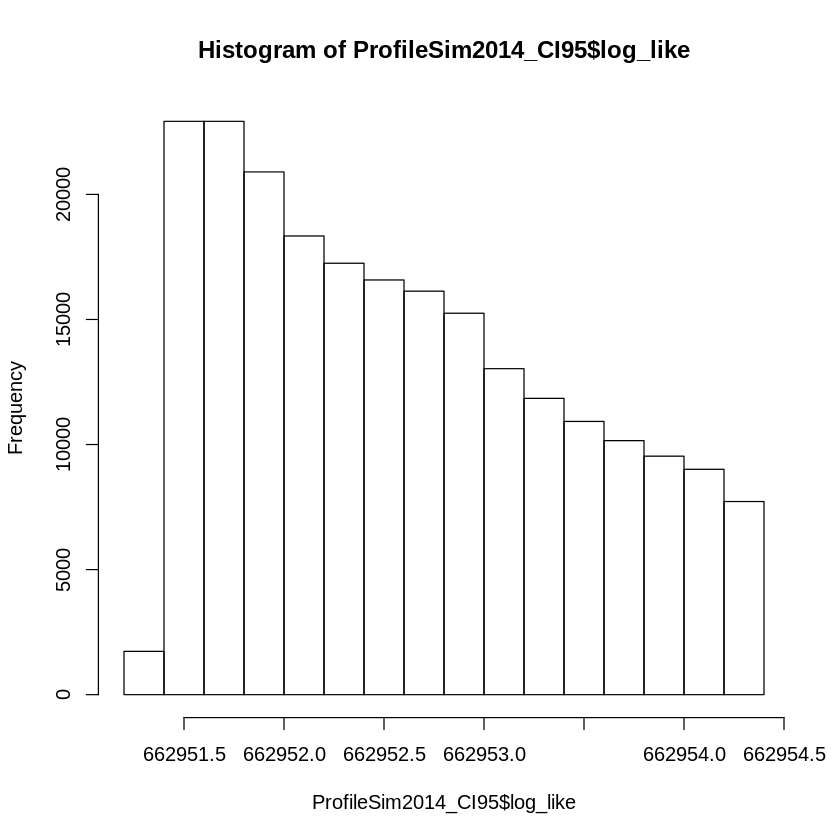

In [14]:
hist(ProfileSim2014_CI95$log_like)

In [12]:
ProfileSim2014[log_like==min(log_like)]
SimKernels
725773.5 -725772.801665672

k_eval,theta_eval,log_like,data_source,time_id,cutoff,best_k,best_theta
-0.6424448,0.6792698,662951.4,simulation_08PLD,2014,662954.4,0.07565334,0.5641438


time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-0.38751254,0.6370261,3.778224,2.096410,9.305059,-725758.2,simulation_08PLD
annual,2013,-0.64237719,0.6792543,4.080705,2.351905,9.967812,-662951.4,simulation_08PLD
annual,2014,0.07565334,0.5641438,3.504783,1.797263,8.749074,-629397.4,simulation_08PLD
interannual,2012-4,-0.31231809,0.6214930,3.770613,2.060501,9.314044,-2021633.6,simulation_08PLD
season,Amihan,-0.43151979,0.6569262,3.617719,2.044842,8.875493,-1864791.3,simulation_08PLD
season,Habagat,0.23883526,0.4673893,6.354512,2.826102,16.085780,-128013.1,simulation_08PLD


[1] 0.6983343

In [18]:
GenPlusSimKernels95CI[k_eval >= best_k & theta_eval >= best_theta][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "upper"][
    log_like ==max_log_like, .(upper_k, upper_theta), by=.(time_id, data_source)]

time_id,data_source,upper_k,upper_theta
2012,genetics,-3.19966136,4.3371990
2013,genetics,-3.19129800,5.0000000
2013,genetics,-3.19129800,5.0000000
2014,genetics,2.50550738,0.2676247
2012-4,genetics,-0.11568816,0.4528655
Amihan,genetics,0.85565794,0.4137350
Habagat,genetics,-3.32407074,5.0000000
2012,simulation_08PLD,-0.38561802,0.6371911
2013,simulation_08PLD,-0.64154388,0.6796926
2014,simulation_08PLD,0.07603351,0.5645354


In [ ]:
GenPlusSimKernels95CI[time_id=="2014" & data_source =="simulation_08PLD"]

In [ ]:
20.26073>20.26023

In [20]:
GenPlusSimKernels95CILower <- GenPlusSimKernels95CI[k_eval <= best_k & theta_eval <= best_theta, .(lower_k=k_eval, lower_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "lower"][
    log_like ==max_log_like, .(lower_k, lower_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CIUpper <- GenPlusSimKernels95CI[k_eval >= best_k & theta_eval >= best_theta][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "upper"][
    log_like ==max_log_like, .(upper_k, upper_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CISummary <- unique(GenPlusSimKernels95CILower[GenPlusSimKernels95CIUpper, on=.(time_id, data_source)], by= c("time_id", "data_source"))

GenSummary <- GenPlusSimKernels95CISummary[GenKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]  
SimSummary <- GenPlusSimKernels95CISummary[SimKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]    

SimSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI
GenSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI

KernelFittingSummary <- rbindlist(list(SimSummary, GenSummary))[, -"log_like"]# SimSummary15PLD,
KernelFittingSummary[, `:=`(upper_mdd=round(mean_disp_dist(k = lower_k, theta=lower_theta), 2),
                            lower_mdd=round(mean_disp_dist(k = upper_k, theta=upper_theta), 2),
                            upper_med=round(nleqslv(x = 7, fn = cdf_solve, k=lower_k, theta=lower_theta)$x, 2),
                            lower_med=round(nleqslv(x = 7, fn = cdf_solve, k=upper_k, theta=upper_theta)$x, 2)),
                      by=c("time_id", "data_source")]
setcolorder(KernelFittingSummary, c("data_source", "time_scale", "time_id", "lower_k", "k", "upper_k", "lower_theta", "theta", "upper_theta", "lower_mdd", "mdd", "upper_mdd", "lower_med", "med", "upper_med")) 
KernelFittingSummary
fwrite(KernelFittingSummary, "~/oceanography/script_output/KernelFits/summary_tables/KernelFittingSummary.csv")

time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


data_source,time_scale,time_id,lower_k,k,upper_k,lower_theta,theta,upper_theta,lower_mdd,mdd,upper_mdd,lower_med,med,upper_med,dist90
simulation_08PLD,annual,2012,-0.388,-0.388,-0.386,0.637,0.637,0.637,3.77,3.778224,3.78,2.09,2.096410,2.10,9.305059
simulation_08PLD,annual,2013,-0.645,-0.642,-0.642,0.679,0.679,0.680,4.07,4.080705,4.10,2.35,2.351905,2.36,9.967812
simulation_08PLD,annual,2014,0.074,0.076,0.076,0.564,0.564,0.565,3.49,3.504783,3.51,1.79,1.797263,1.80,8.749074
simulation_08PLD,interannual,2012-4,-0.314,-0.312,-0.312,0.621,0.621,0.622,3.76,3.770613,3.79,2.06,2.060501,2.07,9.314044
simulation_08PLD,season,Amihan,-0.433,-0.432,-0.430,0.657,0.657,0.657,3.61,3.617719,3.62,2.04,2.044842,2.05,8.875493
simulation_08PLD,season,Habagat,0.234,0.239,0.247,0.467,0.467,0.467,6.33,6.354512,6.41,2.81,2.826102,2.85,16.085780
genetics,annual,2012,-3.494,-3.271,-3.200,1.940,3.529,4.337,11.93,13.020000,18.81,11.24,12.020000,15.80,25.080000
genetics,annual,2013,-3.289,-3.275,-3.191,4.372,5.000,5.000,11.75,12.770000,13.03,11.20,12.180000,12.29,23.910000
genetics,annual,2014,1.861,1.972,2.506,0.215,0.260,0.268,32.82,76.000000,836.81,7.88,17.470000,140.81,182.370000
genetics,interannual,2012-4,-0.469,-0.226,-0.116,0.434,0.439,0.453,10.50,13.690000,18.50,4.55,5.770000,7.72,34.740000


In [ ]:
head(GenPlusSimKernels95CI[time_id=="2012" & data_source=="simulation_08PLD"])

In [22]:
#reformat summary table for publication
KernelFittingSummaryPub <- KernelFittingSummary[, .(k=paste(lower_k, k, upper_k),
                                                                                         theta=paste(lower_theta, theta, upper_theta),
                                                                                         mdd=paste(lower_mdd, mdd, upper_mdd)), by=c("data_source", "time_id")]
KernelFittingSummaryPub
fwrite(KernelFittingSummaryPub, "~/oceanography/script_output/KernelFits/summary_tables/KernelFittingSummaryPublication.csv")

data_source,time_id,k,theta,mdd
simulation_08PLD,2012,-0.388 -0.388 -0.386,0.637 0.637 0.637,3.77 3.77822423644382 3.78
simulation_08PLD,2013,-0.645 -0.642 -0.642,0.679 0.679 0.68,4.07 4.08070541961774 4.1
simulation_08PLD,2014,0.074 0.076 0.076,0.564 0.564 0.565,3.49 3.50478307903728 3.51
simulation_08PLD,2012-4,-0.314 -0.312 -0.312,0.621 0.621 0.622,3.76 3.77061337467421 3.79
simulation_08PLD,Amihan,-0.433 -0.432 -0.43,0.657 0.657 0.657,3.61 3.61771857692861 3.62
simulation_08PLD,Habagat,0.234 0.239 0.247,0.467 0.467 0.467,6.33 6.35451159370473 6.41
genetics,2012,-3.494 -3.271 -3.2,1.94 3.529 4.337,11.93 13.02 18.81
genetics,2013,-3.289 -3.275 -3.191,4.372 5 5,11.75 12.77 13.03
genetics,2014,1.861 1.972 2.506,0.215 0.26 0.268,32.82 76 836.81
genetics,2012-4,-0.469 -0.226 -0.116,0.434 0.439 0.453,10.5 13.69 18.5


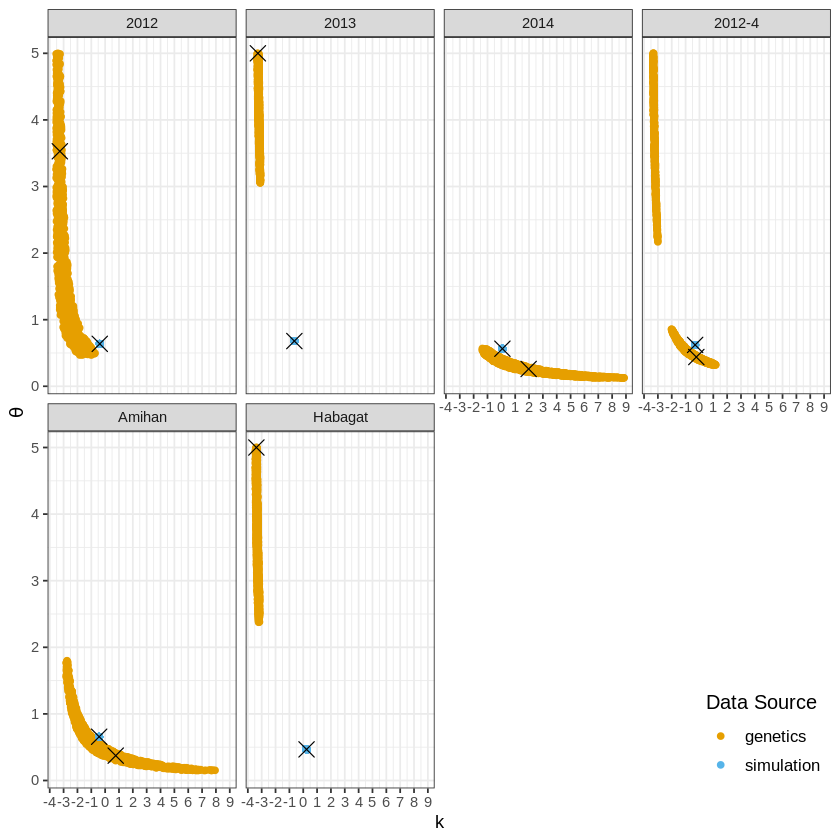

In [24]:
GenPlusSimKernels95CI$time_id <- factor(GenPlusSimKernels95CI$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
#PubKernels$time_id <- factor(PubKernels$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
GenPlusSimKernels95CI$data_source <- factor(GenPlusSimKernels95CI$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

surface <- ggplot() +
        geom_point(data=GenPlusSimKernels95CI[data_source != "simulation_15PLD"][, .SD[sample(.N, 1000, prob=max(log_like)/log_like)], by = c("time_id", "data_source")], aes(x=k_eval, y=theta_eval, color=data_source, fill=data_source)) +
        geom_point(data=KernelFittingSummary[data_source != "simulation_15PLD"], aes(x=k, y=theta),shape=4, size=4) + #, color=data_source, fill=data_source
        #geom_point(data=PubKernels, aes(x=best_k, y=best_theta),shape=8, size=4) + #, color=data_source, fill=data_source
        scale_x_continuous(breaks = seq(-10, 10, by = 1)) + #, expand = c(0, 0)
        scale_y_continuous(breaks = seq(0, 6, by = 1)) +#, expand = c(0, 0)
        theme(axis.text.x = element_text(size=15, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
        axis.text.y =  element_text(size=15, color="black"),
        axis.title.y =  element_text(size=15, color="black"), 
        axis.title.x =  element_text(size=15, color="black")) +
        xlab("k") + ylab(expression(theta)) +
        theme_bw() + 
        scale_colour_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
        scale_fill_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
        facet_wrap(~ time_id, ncol = 4)+
        theme(legend.position = c(1, 0),
        legend.justification = c(1,0),legend.title = element_text(colour="black", size = 12), legend.text = element_text(colour="black", size = 10))
#surface_grid <- surface +facet_grid(cols=vars(time_id), fig.width=6)
surface
#ggsave(filename="SurfaceGrid.pdf",  plot=surface, path="~/oceanography/script_output/plots/", units="in", width=8, height=6)


In [25]:

GenPlusSimKernelsSamp <- GenPlusSimKernels[, .SD[sample(.N, 100, prob=min(log_like)/log_like)], by = c("time_id", "data_source")][ #weight the fits by distance from the best log like
    , `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
                            med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2)),
                      by=c("k_eval", "theta_eval")]



In [30]:
GenPlusSimKernelsSamp95CI <- GenPlusSimKernels95CI[, .SD[sample(.N, 100, prob=min(log_like)/log_like)], by = c("time_id", "data_source")][ #weight the fits by distance from the best log like
    , `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
                            med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2)),
                      by=c("k_eval", "theta_eval")]

In [ ]:
#plot the actual dispersal kernels

In [31]:
#make a dt with the pdf values at each distance to plot for each kernel fit, use 200 kernel fits not 1000

ToPlot <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(GenPlusSimKernelsSamp95CI))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
              do.call("rbind", replicate(length(seq(0, 80, 0.1)), GenPlusSimKernelsSamp95CI[, .(time_id, data_source, k_eval, theta_eval, group=.I)], simplify = FALSE))) #add the group number for plotting

#nrow(ToPlot)==nrow(GenPlusSimKernelsSamp95CI)*length(seq(0, 80, 0.1)) #should be true

#add a column for pdf value at that distance

ToPlot[, pdf := predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval),
                      by=c("k_eval", "theta_eval", "dist_eval")]
BestFits <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(KernelFittingSummary))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
            do.call("rbind", replicate(length(seq(0, 80, 0.1)), KernelFittingSummary[, .(time_id, data_source, k, theta, group=.I)], simplify = FALSE)))[ #add the group number for plotting
            , pdf := predicted_disp(k=k, theta=theta, d=dist_eval),
                      by=c("k", "theta", "dist_eval")]


In [ ]:
 head(ToPlot)

Warning message:
“Removed 8985 row(s) containing missing values (geom_path).”Warning message:
“Removed 93 row(s) containing missing values (geom_path).”Warning message:
“Removed 8985 row(s) containing missing values (geom_path).”Warning message:
“Removed 93 row(s) containing missing values (geom_path).”

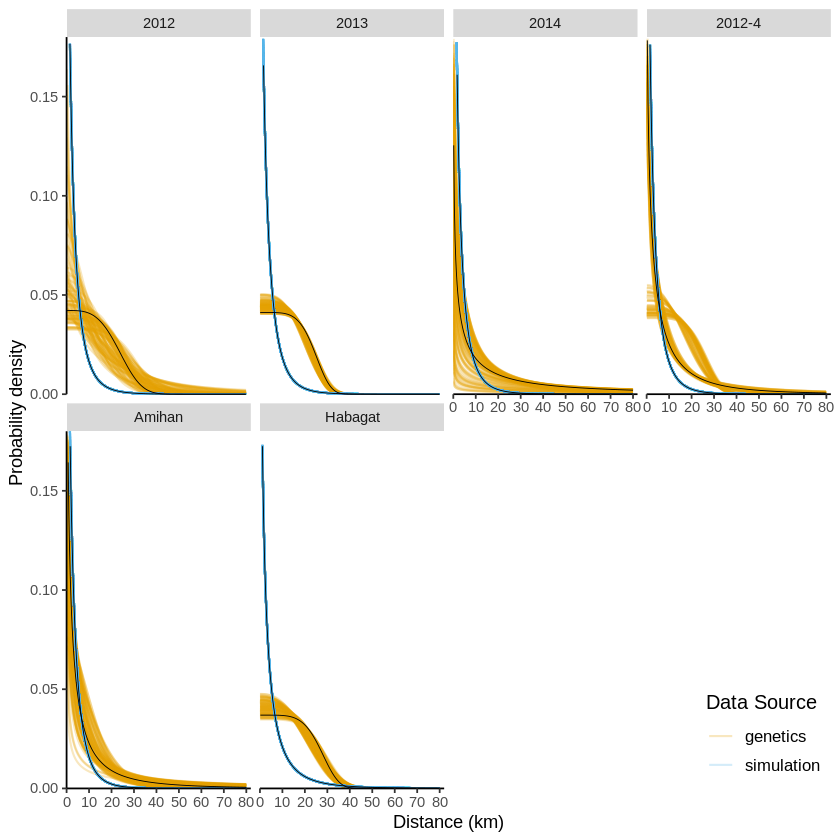

In [33]:
ToPlot$time_id <- factor(ToPlot$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
BestFits$time_id <- factor(BestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
#PubBestFits$time_id <- factor(PubBestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))

#fix the levels for data source so colors are consistent between graphs
ToPlot$data_source <- factor(ToPlot$data_source, levels=c("genetics", "simulation_08PLD"))
BestFits$data_source <- factor(BestFits$data_source, levels=c("genetics", "simulation_08PLD"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("genetics", "simulation_08PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

kernels <- ggplot() + 
    geom_line(data= ToPlot, aes(x=dist_eval, y=pdf, color=data_source, group=group), size=.6, alpha=0.25)+
    geom_line(data=BestFits, aes(x=dist_eval, y=pdf, group=group), color="black", size=0.25) +
    #geom_line(data=BestFits, aes(x=dist_eval, y=pdf, color=data_source, group=group), size=0.3) + #for pub kernels plot
    #geom_line(data=PubBestFits, aes(x=dist_eval, y=pdf, group=group), color="black", size=0.3) +  #for pub kernels plot
      #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2014", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    #geom_vline(data=KernelFittingSummary[data_source != "simulation_15PLD"], aes(xintercept = mdd, color = data_source), linetype="dashed", size=0.6) + 
    #geom_vline(data=KernelFittingSummary[data_source=="simulation"], aes(xintercept = mdd), linetype="dashed", color = "#5ab4ac", size=0.6) +
    #geom_vline(data=PubKernels, aes(xintercept = mdd), linetype="dashed", color = "black", size=0.6) +  #for pub kernels plot
    theme(#legend.position = "bottom",
    legend.key=element_blank(),legend.position = c(1, 0),
    legend.justification = c(1,0),legend.title = element_text(colour="black", size = 12), legend.text = element_text(colour="black", size = 10),
    #axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
   # plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,82), expand = c(0, 0), breaks=c(seq(0, 80, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) + 
    #scale_colour_manual(name = "data_source",values = c("#CC6677","#5ab4ac"))+
    scale_colour_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
    scale_fill_manual(values=cbbPalette, name="Data Source", breaks=c("genetics", "simulation_08PLD"), labels=c("genetics", "simulation"))+
    facet_wrap(~ time_id, ncol = 4) 
kernels
#Facet <- test + facet_grid(.~time_id) +
#  theme(aspect.ratio = 1) #+ ggtitle("2014 Simulations, red line genetics")
#Facet

#ggsave(filename="GenPlusSimKernels.pdf", plot= kernels, path="~/oceanography/script_output/plots/", units="in", width=8, height=6)


In [ ]:
head(BootKernels)

In [ ]:
head(GenPlusSimKernelsSamp)

Saving 6.67 x 6.67 in image


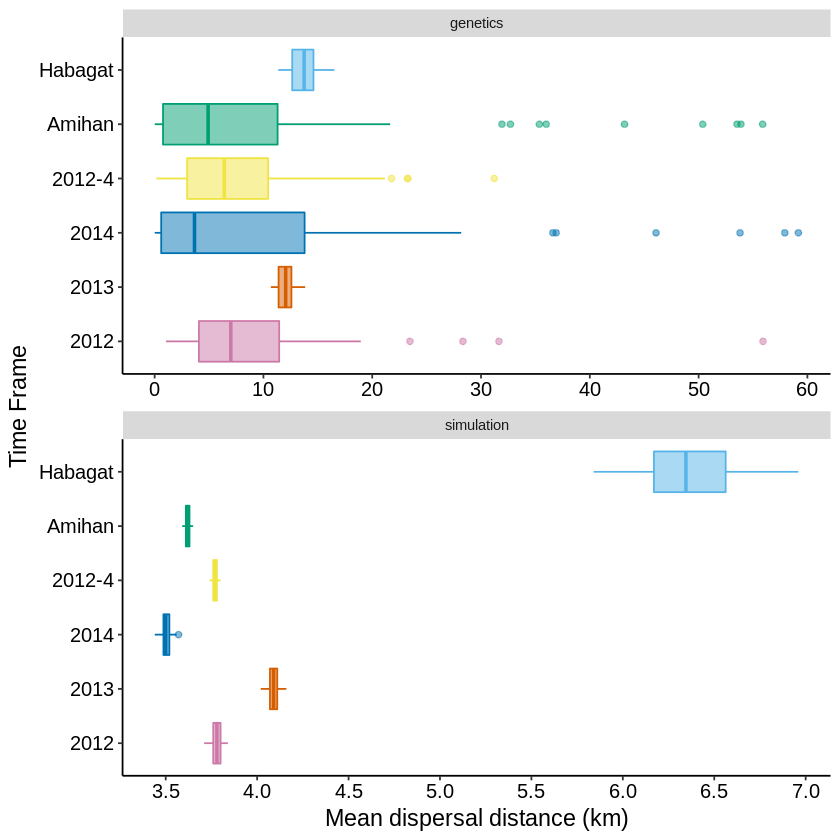

In [36]:
#panel plot of the metrics of interest
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)
GenPlusSimKernelsSamp$time_id <- factor(GenPlusSimKernelsSamp$time_id, levels=c("2012", "2013", "2014", "2012-4", "Amihan", "Habagat"))
GenPlusSimKernelsSamp[data_source=="simulation_08PLD", data_source:="simulation"]
mdd_box <- ggplot() +
    geom_boxplot(data=GenPlusSimKernelsSamp[mdd >0& mdd <60], aes(x=time_id, y=mdd, color=time_id, fill=time_id), alpha=0.5) +
    #geom_point(data=KernelFittingSummary, aes(x=time_id, y=mdd), fill="black",color="darkgray", shape=21) +
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    #scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Time Frame") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=12, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black"),
    axis.title.y =  element_text(size=14, color="black"), 
    axis.title.x =  element_text(size=14, color="black"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)+
    scale_y_continuous(n.breaks = 10) +
    facet_wrap(~ data_source, ncol = 1, scales = "free") 
    
mdd_box
#ggsave(filename="GenPlusSimMDD.pdf", plot= mdd_box, path="~/oceanography/script_output/plots/" )

In [ ]:
GenKernels

In [37]:
#read in the bootstrapped biophysical likelihood results to plot distributions of loglike
BootKernels <- fread("~/oceanography/script_output/KernelFits/BootstrappedBiophysicalKernels08DayPLD.csv")
#BootKernelsSubSamp <- fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels08DayPLDSubSampleSim.csv")
#BootGenKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/Bootstrapped")

#head(BootLike)
#BootKernels[1:100]


data_source,time_scale,time_id,k,theta,num_matches,mdd,med,dist90,log_like,iteration
simulation,annual,2012,-1.7548567,1.2823325,165487,4.331385,3.2745,9.5700,-1.259494e+06,1
simulation,annual,2013,-1.8695528,1.3600242,144844,4.611546,3.5484,10.0908,-1.224612e+06,1
simulation,annual,2014,-1.6742988,1.2183916,152531,4.200274,3.1244,9.3593,-1.102291e+06,1
simulation,total_years,2012-4,-3.0000000,1.0000000,462862,20.085537,13.9222,46.2487,1.600000e+13,1
simulation,monsoonal,NEM,-1.7208725,1.2502071,440548,4.289027,3.2169,9.5162,-3.052947e+06,1
simulation,monsoonal,SWM,-1.9841674,1.4699286,22314,4.866251,3.8271,10.5147,-5.328463e+05,1
simulation_subsample,annual,2012,-1.1670764,0.9102955,3,3.712464,2.4757,8.6803,-1.023137e+02,1
simulation_subsample,annual,2013,-2.3710601,5.0000000,18,5.174145,4.9332,9.6845,-4.757135e+02,1
simulation_subsample,annual,2014,-2.3174165,5.0000000,11,4.903899,4.6755,9.1786,-4.673266e+02,1
simulation_subsample,total_years,2012-4,-2.3503056,3.7602732,32,5.153910,4.7890,9.8657,-1.176034e+03,1


In [42]:
head(GenPlusSimKernelsSamp95CI)

time_id,data_source,k_eval,theta_eval,log_like,cutoff,best_k,best_theta,mdd,med
2012,genetics,-2.9772840,2.0945711,17.59899,20.26073,-3.27091,3.52876,10.88,9.28
2012,genetics,-0.8526599,0.5238235,19.65687,20.26073,-3.27091,3.52876,11.66,5.67
2012,genetics,-3.3653820,1.4862469,20.07071,20.26073,-3.27091,3.52876,19.21,15.15
2012,genetics,-3.1784151,2.4668291,17.49304,20.26073,-3.27091,3.52876,12.64,11.11
2012,genetics,-2.9362080,2.3033988,18.83676,20.26073,-3.27091,3.52876,10.12,8.78
2012,genetics,-3.3356373,3.0479149,18.00851,20.26073,-3.27091,3.52876,14.17,12.84


In [44]:
cor.test(GenPlusSimKernelsSamp95CI[mdd >0 & data_source=="simulation_08PLD" & time_id %in% c("2012", "2013", "2014"), mdd], GenPlusSimKernelsSamp95CI[mdd >0 & data_source=="genetics"& time_id %in% c("2012", "2013", "2014"), mdd], method="spearman")



Warning message in cor.test.default(GenPlusSimKernelsSamp95CI[mdd > 0 & data_source == :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  GenPlusSimKernelsSamp95CI[mdd > 0 & data_source == "simulation_08PLD" &  and GenPlusSimKernelsSamp95CI[mdd > 0 & data_source == "genetics" &     time_id %in% c("2012", "2013", "2014"), mdd] and     time_id %in% c("2012", "2013", "2014"), mdd]
S = 7798147, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.7329407 


In [40]:
cor.test(KernelFittingSummary[data_source=="simulation_08PLD" & time_scale=="annual", mdd], KernelFittingSummary[data_source=="genetics" & time_scale=="annual", mdd], method="spearman")



	Spearman's rank correlation rho

data:  KernelFittingSummary[data_source == "simulation_08PLD" & time_scale ==  and KernelFittingSummary[data_source == "genetics" & time_scale ==     "annual", mdd] and     "annual", mdd]
S = 8, p-value = 0.3333
alternative hypothesis: true rho is not equal to 0
sample estimates:
rho 
 -1 


In [38]:
cor.test(BootKernels[data_source=="simulation" & time_scale=="annual", mdd], BootKernels[data_source=="genetics" & time_scale=="annual", mdd], method="spearman")
cor.test(BootKernels[data_source=="simulation_subsample" & time_scale=="annual", mdd], BootKernels[data_source=="genetics" & time_scale=="annual", mdd], method="spearman")


Warning message in cor.test.default(BootKernels[data_source == "simulation" & time_scale == :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  BootKernels[data_source == "simulation" & time_scale == "annual",  and BootKernels[data_source == "genetics" & time_scale == "annual",     mdd] and     mdd]
S = 7746551148, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
-0.721456 


Warning message in cor.test.default(BootKernels[data_source == "simulation_subsample" & :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  BootKernels[data_source == "simulation_subsample" & time_scale ==  and BootKernels[data_source == "genetics" & time_scale == "annual",     "annual", mdd] and     mdd]
S = 4791057246, p-value = 0.0003928
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06467951 


In [ ]:
#pdf(file = "~/oceanography/script_output/plots/MedCorrelation.pdf")
MDDCor <- plot(BootKernels[data_source=="simulation" & time_scale=="annual", med], BootKernels[data_source=="genetics" & time_scale=="annual", med], xlab="Simulation median dispersal distance (km)", ylab="Genetic median dispersal distance (km)")
#dev.off()
#plot(BootKernelsSubSamp[data_source=="simulation" & time_scale=="annual", med], BootKernelsSubSamp[data_source=="genetics" & time_scale=="annual", med], xlab="Simulation median dispersal distance (km)", ylab="Genetic median dispersal distance (km)")

In [45]:
#plot the variation (CV) to see if the scale of variation matches genetics and simulations
KernelFitsForCV <- rbind(GenKernels, SimKernels) #the number of decimal places in bootstrapped and best fit data should be consistent, use this table because there's no rounding
MLEVariation <-KernelFitsForCV[time_scale != "interannual",.( cv_theta=round(cv(theta),3), cv_mdd=round(cv(mdd),3)), by=c("data_source", "time_scale")]   
MLEVariation

fwrite(MLEVariation, "~/oceanography/script_output/KernelFits/summary_tables/VariationSummary.csv")

data_source,time_scale,cv_theta,cv_mdd
genetics,annual,0.828,1.074
genetics,season,1.218,0.072
simulation_08PLD,annual,0.093,0.076
simulation_08PLD,season,0.238,0.388


In [ ]:
nrow(BootKernels)
nrow(BootKernels[num_matches ==0])

In [46]:
#get a distribution of CV for bootstrapped biophysical kernels

#BootBioPhys <-fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels08DayPLD.csv")[, data_source := "simulation_08PLD"][#fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels15DayPLD.csv")[, data_source := "simulation_15PLD"])
#    , prop1 :=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 1, method = "pcubature")$integral*2, 3),by=c("time_scale","data_source","k", "theta", "iteration")][
#     , prop30 :=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 30, method = "pcubature")$integral*2, 3),by=c("time_scale","data_source", "k", "theta","iteration")][
#    , dist99 :=round(nleqslv(x = 7, fn = cdf_solve99, k=k, theta=theta)$x, 2),by=c("time_scale","data_source","k", "theta", "iteration")]
#
#read in the bootstrapped kernels to compare distribution of CV 

   

BootBioPhysCV <- BootKernels[time_scale != "total_years" & num_matches>0 ,.( cv_theta=round(cv(theta),3), cv_mdd=round(cv(mdd),3)), by=c("time_scale","data_source", "iteration")] #, sd_kurtosis=round(sd(kurtosis), 2) 

In [52]:
#ToPlotVariation <- melt(MLEVariation, id.vars=c("data_source","time_scale"))
ToPlotBoot <- melt(BootBioPhysCV, id.vars=c("iteration","time_scale", "data_source"))

#head(ToPlotVariation)
head(ToPlotBoot)


iteration,time_scale,data_source,variable,value
1,annual,simulation,cv_theta,0.055
1,monsoonal,simulation,cv_theta,0.114
1,annual,simulation_subsample,cv_theta,0.649
1,monsoonal,simulation_subsample,cv_theta,0.229
1,annual,genetics,cv_theta,1.245
1,monsoonal,genetics,cv_theta,0.403


In [ ]:
#test <- rbind(ToPlotBoot[, stat := "boot"], ToPlotVariation[,stat := "MLE"], fill=TRUE)
#tail(test)

Saving 6.67 x 6.67 in image


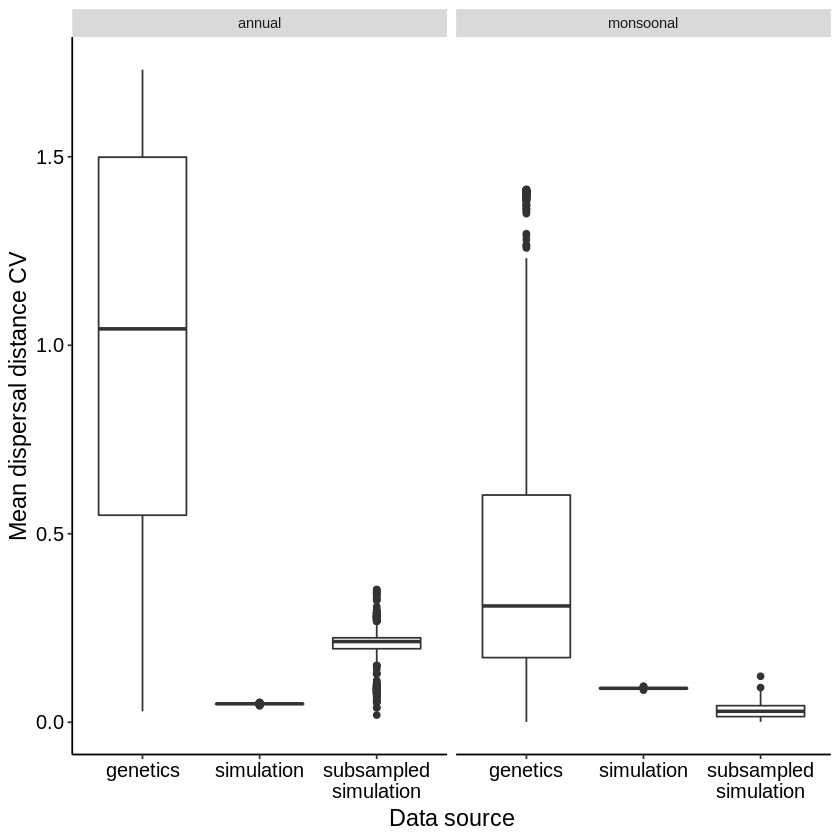

In [54]:
#ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"
#ToPlotBoot$data_source <- factor(ToPlotBoot$data_source, levels=c("genetics", "subsampled simulation", "simulation"))#, "simulation_15PLD"
#test$data_source <- factor(test$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

CVPlotAnnual <- ggplot(data=ToPlotBoot[variable=="cv_mdd"  & value >0], aes(x=data_source , y=value)) +#& data_source!="simulation_subsample"
    geom_boxplot(data=ToPlotBoot[variable=="cv_mdd"  & value >0]) +#aes(x=data_source, y=value, color=time_scale)#, binwidth = 0.005 # & data_source!="simulation_subsample"
    #geom_histogram(data=ToPlotBoot[variable !="sd_k" & time_scale=="annual"& data_source=="simulation_15PLD"], aes(x=value), color="#CC79A7", fill="#CC79A7", binwidth = 0.005) +
    #geom_point(data=test[stat== "MLE" & data_source =="genetics" &variable=="cv_mdd"]) + #, aes(x=data_source, y=value,  color=time_scale)
    ylab("Mean dispersal distance CV") +
    xlab("Data source")+
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=12, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black"),
    axis.title.x =  element_text(size=14, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black"))+
    scale_x_discrete(labels=c("genetics","simulation", "subsampled\nsimulation"))+ # "subsampled\nsimulation",
    #scale_colour_manual(values=cbbPalette)+
    #scale_fill_manual(values=cbbPalette)+
    facet_wrap(~  time_scale, ncol = 2) 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlotAnnual

ggsave(filename="BootstrappedCVComparisonBothTimeScalesMDDSubSampledSim.pdf", plot= CVPlotAnnual, path="~/oceanography/script_output/plots/" )


In [55]:
#likelihood plot
BootLike <- fread(file="~/oceanography/script_output/KernelFits/BootstrappedBiophysicalLikelihoods08DayPLD.csv")[
    ,time_scale := ifelse(time_scale %like% "monsoon", "monsoonal", "annual")]

head(BootLike)

comparison,time_scale,data_source,log_like,iteration
gen_total_bio_total,annual,simulation,-56924.780,1
gen_annual_bio_annual,annual,simulation,-45206.908,1
gen_monsoonal_bio_monsoonal,monsoonal,simulation,-14890.595,1
gen_monsoonal_bio_total,monsoonal,simulation,-36210.048,1
gen_total_bio_total,annual,simulation_subsample,-8521.242,1
gen_annual_bio_annual,annual,simulation_subsample,-4999.046,1


In [ ]:
#how often is each comparison a better fit? WRONG figure out another time
#sum(isTRUE(BootLike[comparison=="gen_monsoonal_bio_total", .(log_like)]<BootLike[comparison=="gen_monsoonal_bio_monsoonal", .(log_like)]))
#test <- BootLike[comparison=="gen_total_bio_total", .(log_like)]<BootLike[comparison=="gen_annual_bio_annual", .(log_like)]


In [ ]:
tail(BootLike[data_source=="simulation_subsample"])

Warning message:
“Removed 14 rows containing missing values (geom_bar).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 14 rows containing missing values (geom_bar).”

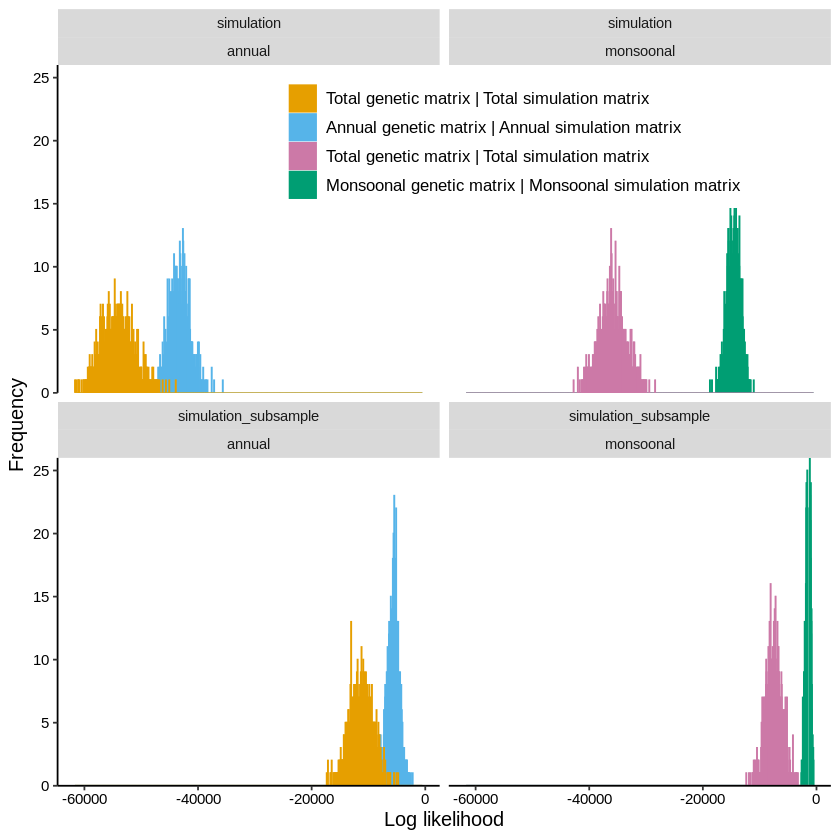

In [60]:
cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7", "#009E73")#"#F0E442", "#0072B2", "#D55E00", "#CC79A7")
#BootLike$comparison <- factor(BootLike$comparison, levels=c("gen_annual_bio_annual", "gen_total_bio_total", "mc"), labels=c("MBB", "MAA", "MCC"))


likelihood_hist <- ggplot() +
    geom_histogram(data=BootLike, aes(x=log_like, fill=comparison, color = comparison), binwidth = 30) +
    ylab("Frequency") +
    xlab("Log likelihood")+
    scale_y_continuous(expand = c(0,0), limits = c(0,26)) + 
    #scale_x_continuous(expand = c(0,0), limits = c(0,26)) + 
    theme(legend.title = element_blank(),
    legend.key=element_blank(),
    legend.position = c(0.6, 0.9), 
    legend.text = element_text(colour="black", size = 10),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),
    axis.title.y =  element_text(size=12, color="black"),
    axis.title.x =  element_text(size=12, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=9, color="black"), 
    axis.text.x =  element_text(size=9, color="black"))+
    scale_colour_manual(values=cbbPalette, breaks=c("gen_total_bio_total","gen_annual_bio_annual","gen_monsoonal_bio_total", "gen_monsoonal_bio_monsoonal"),
                      labels=c("Total genetic matrix | Total simulation matrix", "Annual genetic matrix | Annual simulation matrix", "Total genetic matrix | Total simulation matrix", "Monsoonal genetic matrix | Monsoonal simulation matrix"))+
    scale_fill_manual(values=cbbPalette, breaks=c("gen_total_bio_total","gen_annual_bio_annual","gen_monsoonal_bio_total", "gen_monsoonal_bio_monsoonal"),
                      labels=c("Total genetic matrix | Total simulation matrix", "Annual genetic matrix | Annual simulation matrix", "Total genetic matrix | Total simulation matrix", "Monsoonal genetic matrix | Monsoonal simulation matrix"))+
facet_wrap( ~ data_source+time_scale) 
likelihood_hist

#ggsave(filename="BootstrappedLikelihoodComparisonBothTimeScalesHistogramSubSampledSim.pdf", plot= likelihood_hist, path="~/oceanography/script_output/plots/")


In [59]:
BootLike[time_scale=="years" &log_like > -10000]

comparison,time_scale,data_source,log_like,iteration


In [ ]:
lower_peak <- unique(BootLike[comparison=="gen_annual_bio_annual" & log_like < -30000, iteration])

In [ ]:
summary(BootKernels[time_scale != "monsoonal" &iteration %in% lower_peak])
summary(BootKernels[time_scale != "monsoonal" &iteration %!in% lower_peak])

In [ ]:
ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

CVPlotMonsoon <- ggplot() +
    geom_violin(data=ToPlotBoot[variable !="sd_k" & time_scale=="season"& data_source != "simulation_15PLD"], aes(x=data_source, y=value)) +#, binwidth = 0.005
    #geom_histogram(data=ToPlotBoot[variable !="sd_k" & time_scale=="annual"& data_source=="simulation_15PLD"], aes(x=value), color="#CC79A7", fill="#CC79A7", binwidth = 0.005) +
    geom_point(data=ToPlotVariation[variable !="sd_k"& variable != "sd_kurtosis" &time_scale=="season"& data_source != "simulation_15PLD"], aes(x=data_source, y=value)) +
    ylab("Frequency") +
    xlab("variation")+
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"))+
    scale_colour_manual(values=cbbPalette)+
    scale_fill_manual(values=cbbPalette)+
    facet_wrap(~  variable, ncol = 2, scales = "free") 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlotMonsoon

#ggsave(filename="BootstrappedCVComparisonMonsoon.png", plot= CVPlotMonsoon, path="~/oceanography/script_output/plots/" )

In [ ]:
#relationship with enso?
#annual&monsoon fits and 2011 as well
#define monsoon months
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)
#load data
AnnualMonsoonKernels <- fread(file="~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFitsAnnualMonsoon08DayPLD.csv")
enso <- fread(file="~/oceanography/empirical_data/environment/enso/meiv2.csv")
#setnames(enso, "YEAR", "year")
setnames(enso, c("YEAR","DJ", "JF", "FM", "MA", "AM", "MJ", "JJ", "JA", "AS", "SO", "ON", "ND"), c("year","12,1", "1,2", "2,3", "3,4", "4,5", "5,6", "6,7", "7,8", "8,9", "9,10", "10,11", "11,12"))
#reshape to join
ENSO <- melt(enso, id.vars="year", variable.name = "month_window", value="mei_index")[, `:=`(year=as.numeric(year), month_window=as.character(month_window))][
    year %in% c(2010,2011, 2012, 2013, 2014)][
    , paste0("month", 1:2) := tstrsplit(month_window, ",")]#split the month window column so each month/year combo has a row 

ENSOMonthly <- unique(melt(ENSO[,-"month_window"], id.vars=c("year", "mei_index"), value.name="month")[,-"variable"][#reshape so each month/year combo has a row
    , month := as.numeric(month)][ # to match list of monsoon months
    , monsoon := ifelse(month %in% NEM, "NEM", "SWM")][ #use unique because each month has 2 measurements of mei because it's measured in two month windows. just take the first value so it's consistent
    , year_sampled := ifelse(month %in% SWM, year+1, ifelse(month %in% c(11,12), year+1, year))][ #to match the way we divided years, if there is a SWM fit, it's the data from the year preceding it's "year_sampled" based on our field season timing. If it's the NEM months, then it is a part of the NEM  year that season ends, so a NEM month in 2012 could be any month before June in 2012 but also any month after October in 2011 
    , time_id := paste0(monsoon, year_sampled)][#make a time_id column to join with annual monsoon summary table
    , month_avg_mei_index := mean(mei_index), by=c("month", "year")][
    , annual_monsoon_avg_mei := mean(month_avg_mei_index), by=c("time_id")], by="time_id")

#join kernels and ENSO data together
AnnualMonsoonENSO <- left_join(AnnualMonsoonKernels, ENSOMonthly, by="time_id")

In [ ]:
AnnualMonsoonENSO 

In [ ]:

plot(AnnualMonsoonENSO$mdd, AnnualMonsoonENSO$annual_monsoon_avg_mei)
test_mod <- lm(data=AnnualMonsoonENSO, mdd ~ annual_monsoon_avg_mei+ monsoon)
summary(test_mod)

In [ ]:
MonsoonKernelsENSO <- ggplot() +
    geom_point(data=AnnualMonsoonENSO, aes(x=annual_monsoon_avg_mei, y=mdd, color=monsoon), size=2.5) +
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
    ylab("Mean dispersal distance (km)")+
    xlab("Average monsoon MEI index")
MonsoonKernelsENSO
#ggsave(filename="MonsoonKernelsENSO.png",  plot=MonsoonKernelsENSO, path="~/oceanography/script_output/plots/", units="in")


In [ ]:
ENSOMonthly

In [ ]:
ggplot() +
    geom_point(data=AnnualKernelsENSO[data_source=="simulation"], aes(x=annual_avg_mei, y=mdd))